In [114]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

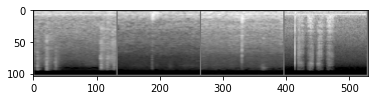

Silence Fingertip Tap Fingernail Tap W Scratch
The one-hot classes are: 
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])
0 1.7340239882469177 0.1095890410958904
1 1.7823442220687866 0.136986301369863
2 1.5593470931053162 0.5342465753424658
3 1.4162891507148743 0.5753424657534246
4 1.7533865571022034 0.136986301369863
5 1.0610408186912537 0.5205479452054794
6 1.7585766315460205 0.2602739726027397
7 1.9626872539520264 0.1232876712328767
8 1.3776859045028687 0.547945205479452
9 1.733263611793518 0.3424657534246575
10 1.3646925687789917 0.4657534246575342
11 1.8604666590690613 0.0
12 1.4143173694610596 0.5616438356164384
13 1.8077287673950195 0.136986301369863
14 1.7182629704475403 0.2876712328767123
15 1.4360015392303467 0.4520547945205479
16 1.4514588713645935 0.3561643835616438
17 1.0973365902900696 0.589041095890411
18 1.7977708578

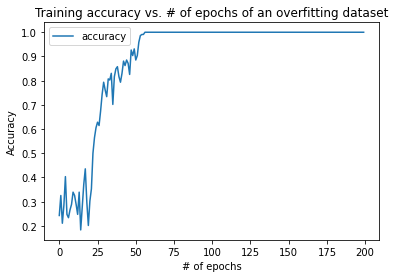

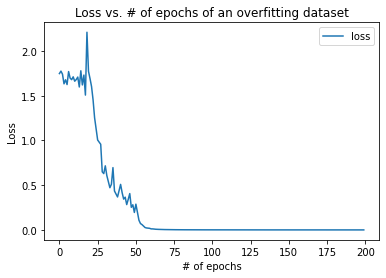

[[12  0  0  1  0  0]
 [ 0  5  0  0  0  0]
 [ 0  3 15  0  0  0]
 [ 1  0  0  9  0  0]
 [ 0  0  0  0 14  0]
 [ 0  0  0  0  0 13]]


In [117]:
# Hyperparameters
numOfConvLayers = 4
numOfKernels = 12
numOfNeurons = 12
learningRate = 0.1
batchSize = 48
numOfEpochs = 200
kernelSize = 3
activation = F.relu       
optimizer_func = torch.optim.SGD
loss_fnc = nn.CrossEntropyLoss()
batchNorm = False
numOfFCLayers = 2
testSize = 0.2
valSize = 0.2
seed = 42
resizeMethod = "scale"


# Input overfit, train, val, test dataset 
# Load un-normalized data to compute mean and standard deviation.
image_size = (100, 130) # size of the input image we want to pass into the model (100 height is standard already)
                       # In our dataset, (100, 65) is size of the smallest image,
                       # (100, 130) is size of the biggest image.
ResizeMethods = {"pad": [SquarePad()], 
                 "crop": [transforms.CenterCrop(image_size)], 
                 "scale": [transforms.Resize(image_size)]
                 }

# Custom Horizontal Pad Pipeline 
class SquarePad:
  def __call__(self, image):
    w = image.size[0]  
    maxw = 130            #pad to 130
    hp = (maxw - w) // 2
    remainder = (maxw - w) % 2
    padding = (hp, 0, hp+remainder, 0)
    return transforms.functional.pad(image, padding, 0, 'constant')
  

# padding/cropping pipeline for unnormalized dataset
data_pipe = transforms.Compose(ResizeMethods[resizeMethod] +
    [transforms.ToTensor()])

path = '/content/drive/My Drive/Colab Notebooks/AirUI/Overfit_Spectrograms'
overfit_path = '/content/drive/My Drive/Colab Notebooks/AirUI/Overfit_Spectrograms'
dataset_raw = torchvision.datasets.ImageFolder(\
            root=path, \
            transform=data_pipe)
loader = DataLoader(dataset_raw, batch_size=len(dataset_raw))
data = next(iter(loader))
mean = torch.mean(data[0], (0,2,3))
std = torch.std(data[0], (0,2,3))
overfit_raw = torchvision.datasets.ImageFolder(\
            root=overfit_path, \
            transform=data_pipe)
loader = DataLoader(overfit_raw, batch_size=len(overfit_raw))
data = next(iter(loader))
mean_overfit = torch.mean(data[0], (0,2,3))
std_overfit = torch.std(data[0], (0,2,3))

# padding/cropping pipeline for normalized datasets
data_pipeline_normal_reg = transforms.Compose(ResizeMethods[resizeMethod] + 
    [transforms.ToTensor(), transforms.Normalize(mean, std)])
data_pipeline_normal_over = transforms.Compose(ResizeMethods[resizeMethod] + 
    [transforms.ToTensor(), transforms.Normalize(mean_overfit, std_overfit)])

# Normalized dataset
dataset = torchvision.datasets.ImageFolder(\
            root=path, \
            transform=data_pipeline_normal_reg)
overfit_set = torchvision.datasets.ImageFolder(\
            root=overfit_path, \
            transform=data_pipeline_normal_reg)

# create train, val, test, and overfit dataset
train_set, test_set = train_test_split(dataset, test_size=testSize, random_state=seed)   # split test
train_set, val_set = train_test_split(train_set, test_size=valSize/(1-testSize), random_state=seed)   # split train to train and val

train_loader = DataLoader(train_set, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batchSize, shuffle=True)
overfit_loader = DataLoader(overfit_set, batch_size=batchSize, shuffle=True)

# Check the ground truth of the images
def imshow(img):
  img[0] = img[0] * std[0] + mean[0]     # De-normalize
  img[1] = img[1] * std[1] + mean[1]     # De-normalize
  img[2] = img[2] * std[2] + mean[2]     # De-normalize
  npimg = img.numpy()
  pyplot.imshow(np.transpose(npimg, (1, 2, 0)))
  pyplot.show()
 
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:4]))
classes = ['Circle Scratch', 'Fingernail Tap', 'Fingertip Tap', 'Silence', 'Vertical Scratch', 'W Scratch'] 
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) 

# One-hot encode the classes
oneh_encoder = OneHotEncoder()
oneh_classes = torch.Tensor(oneh_encoder.fit_transform(np.asarray(classes).reshape(-1, 1)).toarray())
print("The one-hot classes are: ")
print (oneh_classes)


# CNN Model
# Fixed Hyperparameters: two fully connected layers
class CNN(nn.Module):
  def __init__(self, input_dims, numOfKernels, numOfNeurons, kernelSize, numOfConvLayers, batchNorm):
    super(CNN, self).__init__()         
    self.numOfKernels = numOfKernels
    self.batchNorm = batchNorm
    self.numOfConvLayers = numOfConvLayers

    # Convolutional Layers
    self.conv1 = nn.Conv2d(3,numOfKernels, kernelSize)
    self.conv2 = nn.Conv2d(numOfKernels,numOfKernels, kernelSize)
    self.conv_BN = nn.BatchNorm2d(numOfKernels)

    # Determine the output size after the convolutional layer
    fullLayerSize_x = input_dims[1]
    fullLayerSize_y = input_dims[0]
    for i in range (self.numOfConvLayers):
      fullLayerSize_x = (fullLayerSize_x-kernelSize+1)//2
      fullLayerSize_y = (fullLayerSize_y-kernelSize+1)//2

    # Error check the output size
    if fullLayerSize_x <= 0 or fullLayerSize_y <= 0:
      raise Exception("Too many convolutional layer for the input size, please decrease numOfConvLayers.")

    # Fully connected layers
    self.fc1 = nn.Linear(numOfKernels*fullLayerSize_x*fullLayerSize_y, numOfNeurons)
    self.fc1_BN = nn.BatchNorm1d(numOfNeurons)
    self.pool = nn.MaxPool2d(2,2)
    self.fc2 = nn.Linear(numOfNeurons, 6)
    self.fc2_BN = nn.BatchNorm1d(6)

  def forward(self, x):
    if self.batchNorm == True:
      x = self.pool(activation(self.conv_BN(self.conv1(x))))
      for i in range (self.numOfConvLayers - 1):
        x = self.pool(activation(self.conv_BN(self.conv2(x))))
      x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
      x = activation(self.fc1_BN(self.fc1(x)))
      x = self.fc2_BN(self.fc2(x))
    else: 
      x = self.pool(activation(self.conv1(x)))
      for i in range (self.numOfConvLayers - 1):
        x = self.pool(activation(self.conv2(x)))
      x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
      x = activation(self.fc1(x))
      x = self.fc2(x)
    return x



# Evaluation functions
def evaluate(model, data_loader, batchNorm):   # used on validation and test set
  total_corr = 0
  totalLoss = 0
  if batchNorm:
    model.eval()
  else:
    model.train()
  for i, (inputs, labels) in enumerate(data_loader):
    oneh_labels = oneh_classes[labels]
    outputs = model(inputs)
    if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
      loss = loss_fnc(input=outputs, target=labels) 
    else: 
      loss = loss_fnc(input=outputs, target=oneh_labels) 
    total_corr += numOfCorrectPredictions(outputs, labels) 
    totalLoss += loss.item()
  accuracy = float(total_corr)/len(data_loader.dataset)
  loss = totalLoss/len(data_loader)
  return (loss, accuracy)

def numOfCorrectPredictions(Y, L):
  result = Y.argmax(1)      # Get the maximum value in each output and compare it to its label
  return (result == L).sum()



# Train Overfit Model
def overfit_training (data_loader, model, optimizer):
  trainAccuracies = []
  trainLosses = []
  start_time = time.time()
  model.train()
  for epoch in range(numOfEpochs):
    totalLoss = 0
    totalCorrect = 0
    for i, (inputs, labels) in enumerate(data_loader):
      optimizer.zero_grad() 
      outputs = model(inputs)                                  # Get outputs
      oneh_labels = oneh_classes[labels]                       # Get one hot labels
      if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
        loss = loss_fnc(input=outputs, target=labels) 
      else: 
        loss = loss_fnc(input=outputs, target=oneh_labels)  
      loss.backward()                                          # Compute loss gradients
      optimizer.step()                                         # Adjust weights 
      totalCorrect += numOfCorrectPredictions(outputs, labels)
      totalLoss += loss.item()
    
    # Here, my accuracy at each epoch is the average accuracy across the entire epoch;
    # my loss at each epoch is the average loss over the entire epoch
    avg_accuracy = float(totalCorrect) / len(data_loader.dataset) 
    avg_loss = totalLoss/len(data_loader)
    print(epoch, avg_loss, avg_accuracy)
    trainAccuracies += [avg_accuracy]  
    trainLosses += [avg_loss]
  print("total time: ")
  print(time.time()-start_time)
  return trainAccuracies, trainLosses


# Traning loop function for full dataset
def full_training (train_loader, val_loader, test_loader, model, optimizer):
  trainAccuracies = []
  validAccuracies = []
  trainLosses = []
  validLosses = []
  start_time = time.time()
  model.train()
  for epoch in range(numOfEpochs):
    totalCorrect = 0
    totalLoss = 0
    for i, (inputs, labels) in enumerate(train_loader):
      optimizer.zero_grad() 
      outputs = model(inputs)                                  # Get outputs
      oneh_labels = oneh_classes[labels]                       # Get one hot labels
      if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
        loss = loss_fnc(input=outputs, target=labels) 
      else: 
        loss = loss_fnc(input=outputs, target=oneh_labels) 
      loss.backward()                                          # Compute loss gradients
      optimizer.step()                                         # Adjust weights 
      totalCorrect += numOfCorrectPredictions(outputs, labels)
      totalLoss += loss.item()

    # For every epoch, compute the training accuracy and loss
    # Here, my accuracy at each epoch is the average accuracy across the entire epoch;
    # my loss at each epoch is the average loss over the entire epoch
    avg_train_accuracy = float(totalCorrect) / len(train_loader.dataset)
    avg_train_loss = totalLoss/len(train_loader)

    # For every epoch, get accuracy, and loss of the validation data
    (valid_loss, valid_accuracy) = evaluate(model, val_loader, batchNorm)
    print(epoch, valid_loss, valid_accuracy)
    trainAccuracies += [avg_train_accuracy]  
    trainLosses += [avg_train_loss]
    validAccuracies += [valid_accuracy]  
    validLosses += [valid_loss]

  print("total time: ")     # print total time 
  print(time.time()-start_time)
  (test_loss, test_accuracy) = evaluate(model, test_loader, batchNorm)    # evaluate the test data
  print("the test accuracy and loss after CNN model is ", test_accuracy, test_loss)

  return trainAccuracies, trainLosses, validAccuracies, validLosses


# Plotting
# Plot the overfitting results
def plot_overfit(trainAccuracies, trainLosses):
  # Accuracy plot
  pyplot.plot(trainAccuracies, label='accuracy')
  pyplot.legend()
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('# of epochs')
  pyplot.title('Training accuracy vs. # of epochs of an overfitting dataset')
  pyplot.show()

  # Loss plot
  pyplot.plot(trainLosses, label='loss')
  pyplot.legend()
  pyplot.ylabel('Loss')
  pyplot.xlabel('# of epochs')
  pyplot.title('Loss vs. # of epochs of an overfitting dataset')
  pyplot.show()

# Plot the full data results 
def plot_full_data(trainAccuracies, trainLosses, validAccuracies, validLosses):
  # Accuracy plot
  pyplot.plot(trainAccuracies, label='training')
  pyplot.plot(validAccuracies, label='validation')
  pyplot.legend()
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('# of epochs')
  pyplot.title('Training accuracy vs. # of epochs of the full dataset')
  pyplot.show()

  # Loss plot
  pyplot.plot(trainLosses, label='traning')
  pyplot.plot(validLosses, label='validation')
  pyplot.legend()
  pyplot.ylabel('Loss')
  pyplot.xlabel('# of epochs')
  pyplot.title('Loss vs. # of epochs of the full dataset')
  pyplot.show()




######################################### LOAD AND CALL THE MODEL HERE ##############################################
#### TO TEST THE PERFORMANCE OF THE MODEL, ONLY OVERFITTING TRAINNING IS CALLED BELOW
#### TO SEE THE PERFORMANCE ON THE ACTUAL DATASET, SEE SERACH.IPYNB IN THE HYPERPARMETERS SERACH FOLDER

torch.manual_seed(seed)
model = CNN(input_dims=image_size, numOfKernels=8, numOfNeurons=100, kernelSize=3, numOfConvLayers=2, batchNorm=False)    # Load model 
optimizer = optimizer_func(model.parameters(),lr=learningRate)

# Train the overfitting data
# trainAccuracies, trainLosses = overfit_training(train_loader, model, optimizer) #as we can see, the final accuracy reaches 1 --> model is okay!
  
# # Train and plot the full data
trainAccuracies, trainLosses, validAccuracies, validLosses = full_training(train_loader, val_loader, test_loader, model, optimizer)
# plot_full_data(trainAccuracies, trainLosses, validAccuracies, validLosses)


# Display the result ( accuracy plots, confusion matrix)
plot_overfit(trainAccuracies, trainLosses)  
new_val_loader = DataLoader(val_set, batch_size=len(val_set))
for i, (inputs, labels) in enumerate(new_val_loader):
  val_outputs = model(inputs)
  result = val_outputs.argmax(1)
  print(confusion_matrix(result.detach().numpy(),labels.detach().numpy()))

# Save the model
# torch.save(model, 'path')


######################## Accuracy/Loss plots #########################


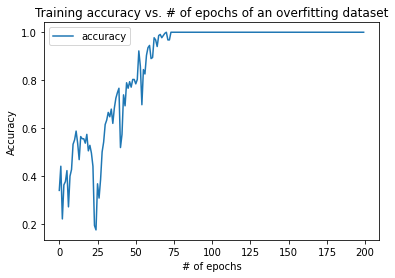

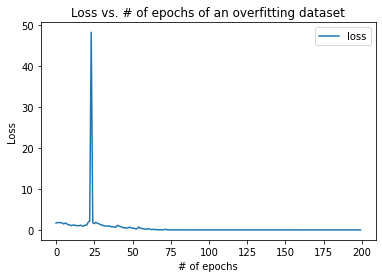

######################## Confusion Matrix #########################
[[13  0  0  1  0  1]
 [ 0  7  1  0  0  0]
 [ 0  1 13  1  0  0]
 [ 0  0  1  7  0  0]
 [ 0  0  0  0 14  0]
 [ 0  0  0  1  0 12]]
########################## ROC curves #############################


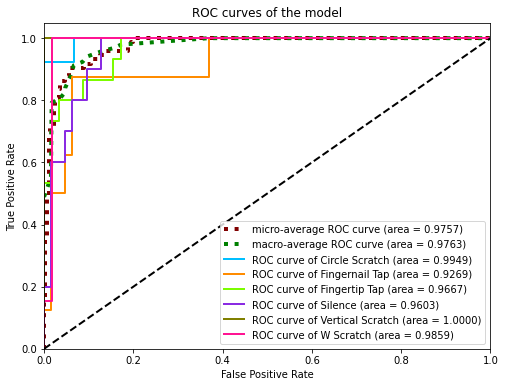

In [78]:
# Display the result (accuracy plots, confusion matrix, ROC curves)
print("######################## Accuracy/Loss plots #########################")
plot_overfit(trainAccuracies, trainLosses)  
new_val_loader = DataLoader(val_set, batch_size=len(val_set))

for i, (inputs, labels) in enumerate(new_val_loader):
  oneh_labels = oneh_classes[labels]
  val_outputs = model(inputs)
  result = val_outputs.argmax(1)
  print("######################## Confusion Matrix #########################")
  print(confusion_matrix(result.detach().numpy(),labels.detach().numpy()))
  print("########################## ROC curves #############################")
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  # Compute the fprs and tprs for each class of the 6 gestures
  for i in range (6): 
    fpr[i], tpr[i], _ = roc_curve(oneh_labels[:, i].detach().numpy(), val_outputs[:, i].detach().numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve((oneh_labels.detach().numpy()).ravel(), (val_outputs.detach().numpy()).ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))    # Combine all fprs
total_tpr = np.zeros_like(all_fpr)    
for i in range(6):
  total_tpr += np.interp(all_fpr, fpr[i], tpr[i])       # Interpolate to get the tprs
avg_tpr = total_tpr/ 6
fpr["macro"] = all_fpr
tpr["macro"] = avg_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


# Plot ROC curves (reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
pyplot.figure(figsize=(8,6))      # 8in x 8in figure
pyplot.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]),
         color='maroon', linestyle=':', linewidth=4)
pyplot.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)
colors = ['deepskyblue', 'darkorange', 'lawngreen', 'blueviolet', 'olive', 'deeppink']
for i in range(6):
  pyplot.plot(fpr[i], tpr[i], color=colors[i], linewidth=2,
             label='ROC curve of {0} (area = {1:0.4f})'
             ''.format(classes[i], roc_auc[i]))

pyplot.plot([0, 1], [0, 1], 'k--', linewidth=2)    # straight line y = x for comparison
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC curves of the model')
pyplot.legend()
pyplot.show()


# Save the model
# torch.save(model, 'path')


